## Install Dependencies

In [ ]:
%pip install control

## Generating Data

In [10]:
import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
s = control.TransferFunction.s

k = 0.1
T1 = 0.1
T2 = 0.1
#G = k / ((T1*s +1)(T2*s +1))
#(G)
# step should be every 5ms 60s / 100ms s
NUM_SAMPLES = 5000
DURATION = 60
T_MESS = 0.2
# Duration of analysis / T_measurement
TIME_STEPS  = int(DURATION / T_MESS)
FEATURES = 3
C_E = 1
print(TIME_STEPS)
t = np.linspace(start= -T_MESS, stop=DURATION -T_MESS, num=TIME_STEPS)
print(t)

K = 0
T1 = 0
T2 = 0

step_func = pd.DataFrame(index=t)
step_func['x_e'] = np.zeros(TIME_STEPS)
step_func.loc[step_func.index > 0, 'x_e'] = 1 * C_E

x_e = step_func['x_e'].values
X = np.zeros((NUM_SAMPLES, TIME_STEPS, FEATURES))

y = np.zeros((NUM_SAMPLES, 3))
# data shape (5000, 300, 3)
#
# 5000 experiments with different parameters
# 3 outputs (K, T1, T2)
features_list = []
labels_list = []
for i in tqdm(range(NUM_SAMPLES)):
    K = np.round(np.random.uniform(1, 10),1)
    val_1 = np.round(np.random.uniform(1, 10),1)
    val_2 = np.round(np.random.uniform(1, 10),1)
    # T1 always bigger to help NN learn consistently
    T1 = max(val_1, val_2)
    T2 = min(val_1, val_2)

    num = [K]
    den = [T1*T2, T1 + T2, 1]

    sys = control.tf(num, den)
    _, x_a = control.forced_response(sys, T=t, U=x_e)
    dx_a_dt = np.gradient(x_a, t)
    X[i, :, 0] = dx_a_dt
    X[i, :, 1] = x_a
    X[i,:, 2] = t
    y[i,:] = [K, T1, T2]
print(y)

300
[-2.00000000e-01  6.68896321e-04  2.01337793e-01  4.02006689e-01
  6.02675585e-01  8.03344482e-01  1.00401338e+00  1.20468227e+00
  1.40535117e+00  1.60602007e+00  1.80668896e+00  2.00735786e+00
  2.20802676e+00  2.40869565e+00  2.60936455e+00  2.81003344e+00
  3.01070234e+00  3.21137124e+00  3.41204013e+00  3.61270903e+00
  3.81337793e+00  4.01404682e+00  4.21471572e+00  4.41538462e+00
  4.61605351e+00  4.81672241e+00  5.01739130e+00  5.21806020e+00
  5.41872910e+00  5.61939799e+00  5.82006689e+00  6.02073579e+00
  6.22140468e+00  6.42207358e+00  6.62274247e+00  6.82341137e+00
  7.02408027e+00  7.22474916e+00  7.42541806e+00  7.62608696e+00
  7.82675585e+00  8.02742475e+00  8.22809365e+00  8.42876254e+00
  8.62943144e+00  8.83010033e+00  9.03076923e+00  9.23143813e+00
  9.43210702e+00  9.63277592e+00  9.83344482e+00  1.00341137e+01
  1.02347826e+01  1.04354515e+01  1.06361204e+01  1.08367893e+01
  1.10374582e+01  1.12381271e+01  1.14387960e+01  1.16394649e+01
  1.18401338e+01  1.2

100%|██████████| 5000/5000 [00:29<00:00, 166.98it/s]

[[3.7 4.4 1.2]
 [2.5 8.5 3.8]
 [8.1 7.9 7.5]
 ...
 [6.3 9.  6. ]
 [2.7 8.8 4.3]
 [2.4 6.3 5. ]]


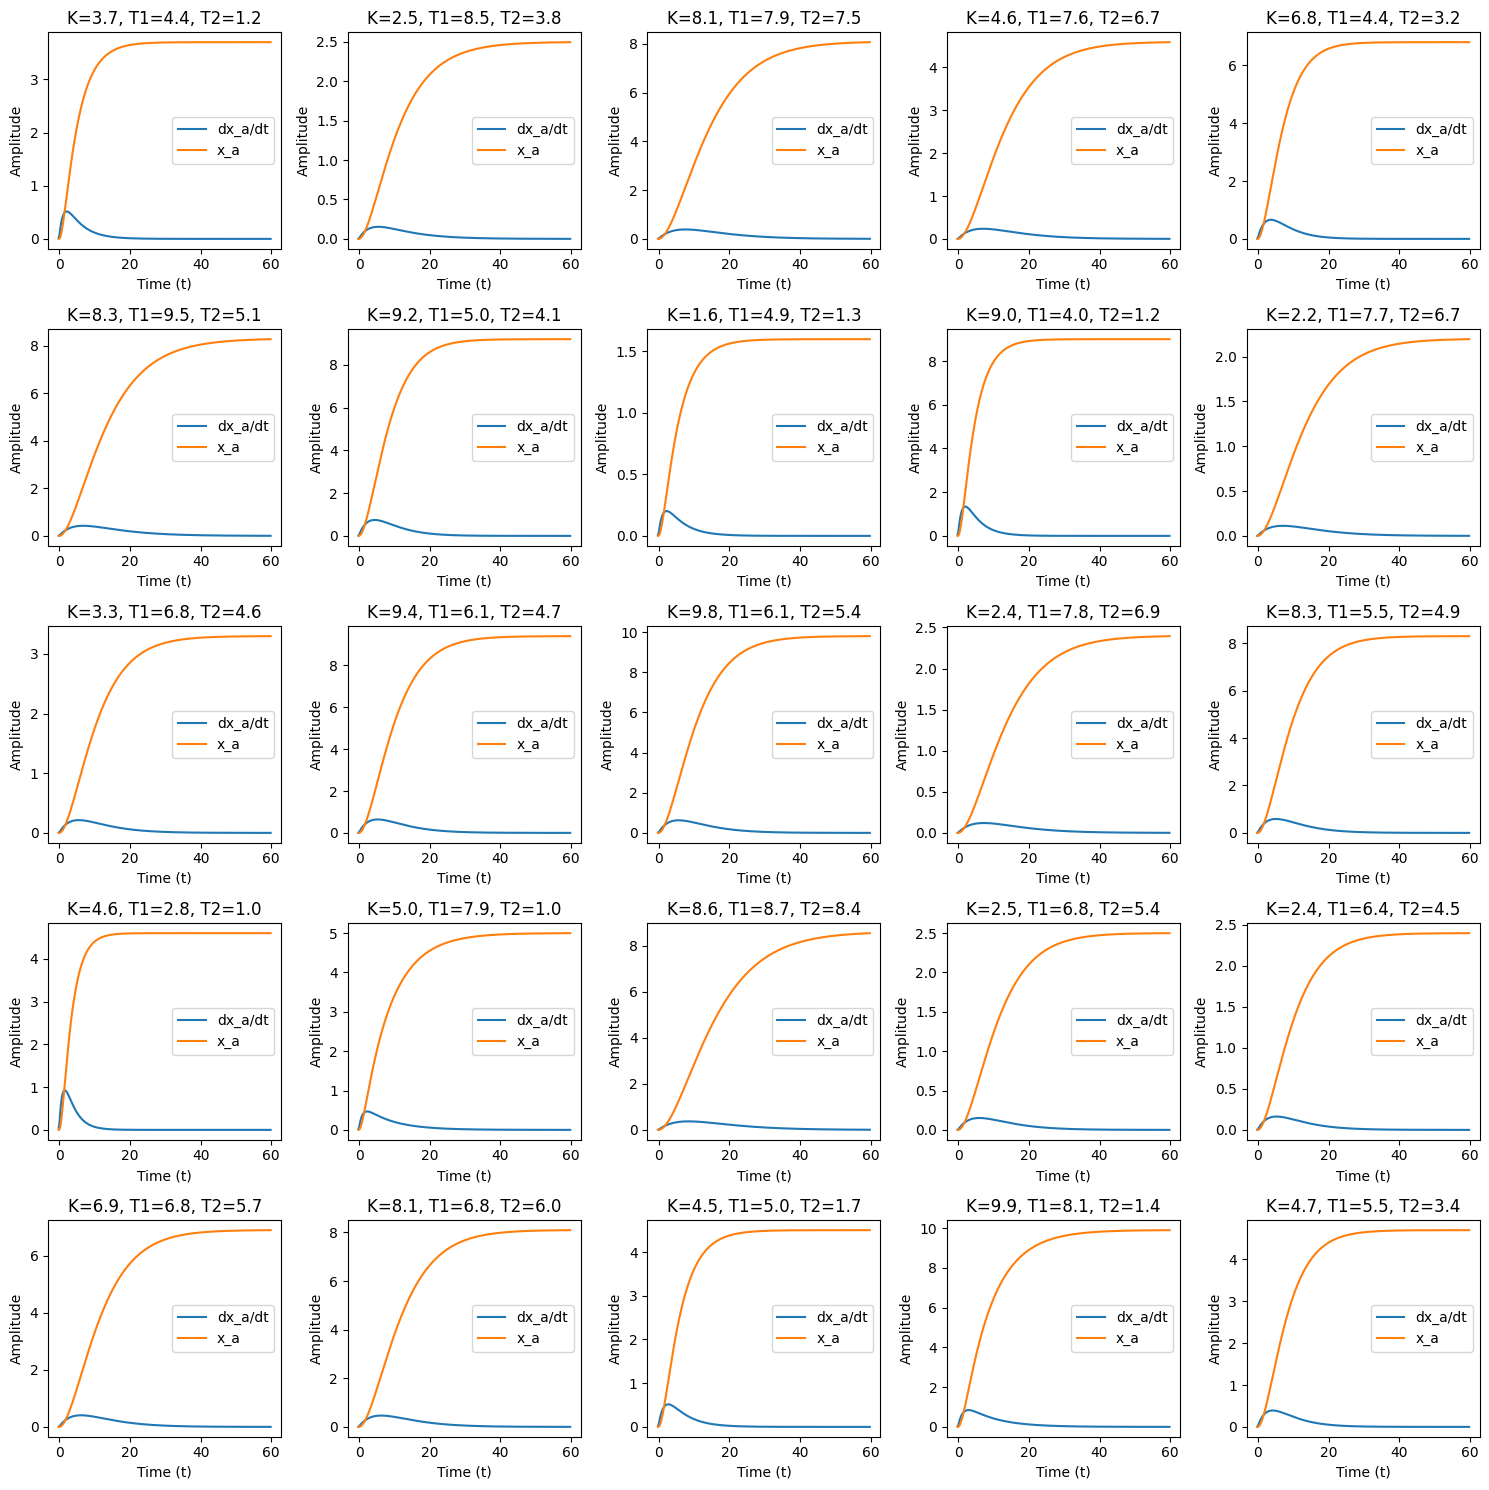

In [12]:
# ...existing code...
responses = X[0:25]
fig, axes = plt.subplots(nrows= 5, ncols=5, figsize=(15,15))
for i,ax in enumerate(axes.flatten()):
    t = responses[i][:, 2]
    da_dt = responses[i][:, 0]
    x_a = responses[i][:, 1]
    K = y[i][0]
    T1 = y[i][1]
    T2 = y[i][2]
    ax.plot(t, da_dt, label='dx_a/dt')
    ax.plot(t, x_a, label='x_a')
    ax.set_title(f'K={K}, T1={T1}, T2={T2}')
    ax.legend()
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Amplitude')

plt.tight_layout() # Adjust subplot params for a tight layout
plt.show() # Display the figure

### Parameters

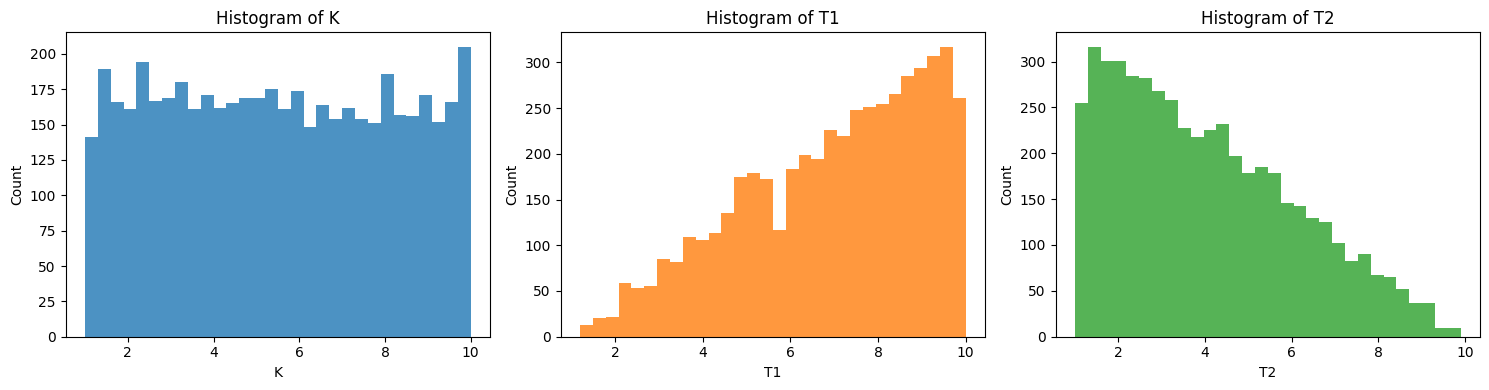

In [13]:
import numpy as np
import matplotlib.pyplot as plt

y = np.asarray(y, dtype=float)  # ensure numeric array, shape (N,3)

labels = ['K', 'T1', 'T2']
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, ax in enumerate(axes):
    ax.hist(y[:, i], bins=30, color=f'C{i}', alpha=0.8)
    ax.set_title(f'Histogram of {labels[i]}')
    ax.set_xlabel(labels[i])
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

### Distributions

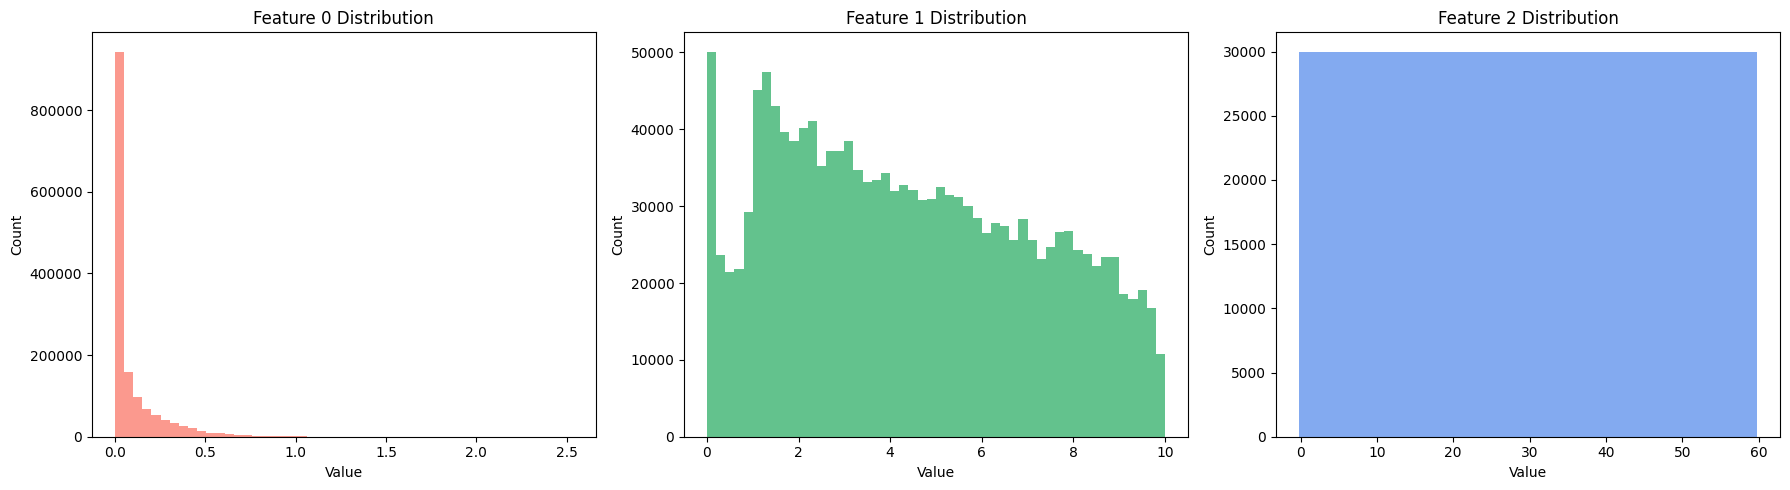

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['salmon', 'mediumseagreen', 'cornflowerblue']
labels = ['Feature 0', 'Feature 1', 'Feature 2']

for i in range(0,3):
  feat = X[:,:,i].flatten()
  # print(feat) # Commenting out print to avoid large output
  axes[i].hist(feat, bins=50, color=colors[i], alpha=0.8)
  axes[i].set_title(f'{labels[i]} Distribution')
  axes[i].set_xlabel('Value')
  axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### TRAINING MODEL



In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

random_state = 42
tf.keras.utils.set_random_seed(random_state)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if len(physical_devices) > 0:
    print(f"Device Name: {physical_devices[0].name}")
else:
    print("⚠️ No GPU found. Training will run on CPU.")


Num GPUs Available:  1
Device Name: /physical_device:GPU:0


### Preprocessing

In [16]:
#X_xa = X[:, : , 1:3] # Corrected: Ensure X_xa remains 3D (samples, timesteps, features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Reshape X_train and X_test for StandardScaler
# StandardScaler expects a 2D array: (n_samples, n_features)
# Here, each 'sample' will be a single time step from all experiments, so we flatten the first two dimensions.
num_samples_train, time_steps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, num_features)

num_samples_test, _, _ = X_test.shape
X_test_reshaped = X_test.reshape(-1, num_features)

# Initialize and fit StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_reshaped) # Fit on training data only

# Transform both training and testing data
X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)

# Reshape back to original 3D shape (num_samples, time_steps, num_features) for Conv1D
X_train_scaled = X_train_scaled_reshaped.reshape(num_samples_train, time_steps, num_features)
X_test_scaled = X_test_scaled_reshaped.reshape(num_samples_test, time_steps, num_features)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print(f"Original X shape: {X.shape}")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Original X shape: (5000, 300, 3)
X_train_scaled shape: (4000, 300, 3)
X_test_scaled shape: (1000, 300, 3)
y_train shape: (4000, 3)
y_test shape: (1000, 3)


### CNN with branching

In [18]:
inputs = Input(shape=(300, 3))
# --- Start Branching ---
# Branch 1: Fast (Microscope)
x = Conv1D(filters=32, kernel_size=8, padding='same', activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
# 3. Output Layer
# Dense(3) matches your request for 3 regression targets
outputs = Dense(3, activation='linear')(x)

# 4. Finalize the Model
model = Model(inputs=inputs, outputs=outputs)

# 5. Compile
optimizer_lr_adjusted = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer_lr_adjusted, loss='mse',metrics = ['r2_score'] )
# 6. Check your architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 300, 32)        │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       614,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,243 (2.39 MB)

 Trainable params: 626,243 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:


# 1. Set up Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',  # Watch the validation loss
    patience=15,         # Wait 15 epochs after it stops improving before killing it
    restore_best_weights=True # Automatically roll back to the best weights when stopped
)

# 2. Set up Model Checkpoint
checkpoint = ModelCheckpoint(
    filepath='best_system_model.keras',
    monitor='val_loss',
    save_best_only=True, # ONLY overwrite the file if the model got better
    verbose=1            # Prints a message when it saves
)

history = model.fit(X_train_scaled, y_train_scaled,
                    epochs=50, batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop, checkpoint],
                    verbose=1)

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3861 - val_loss: 0.1495
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1481 - val_loss: 0.1333
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1168 - val_loss: 0.1014
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0810 - val_loss: 0.0636
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0577 - val_loss: 0.0534
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0512 - val_loss: 0.0619
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0435 - val_loss: 0.0440
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0408 - val_loss: 0.0355
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0313 - val_loss: 0.0303
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0373 - val_loss: 0.0329
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0268 - val_loss: 0.0254
Epoch 12/200
100/100 ━━━━━━━━━━━━━━━━━━━━

# Displaying Results

In [28]:
#loss, mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=1)
loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=1)
print(f"Test Loss: {loss:.4f}")
#print(f"Test MAE: {mae:.4f}")
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_actual = y_scaler.inverse_transform(y_test_scaled)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098
Test Loss: 0.0102
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## SHOW SYSTEMS

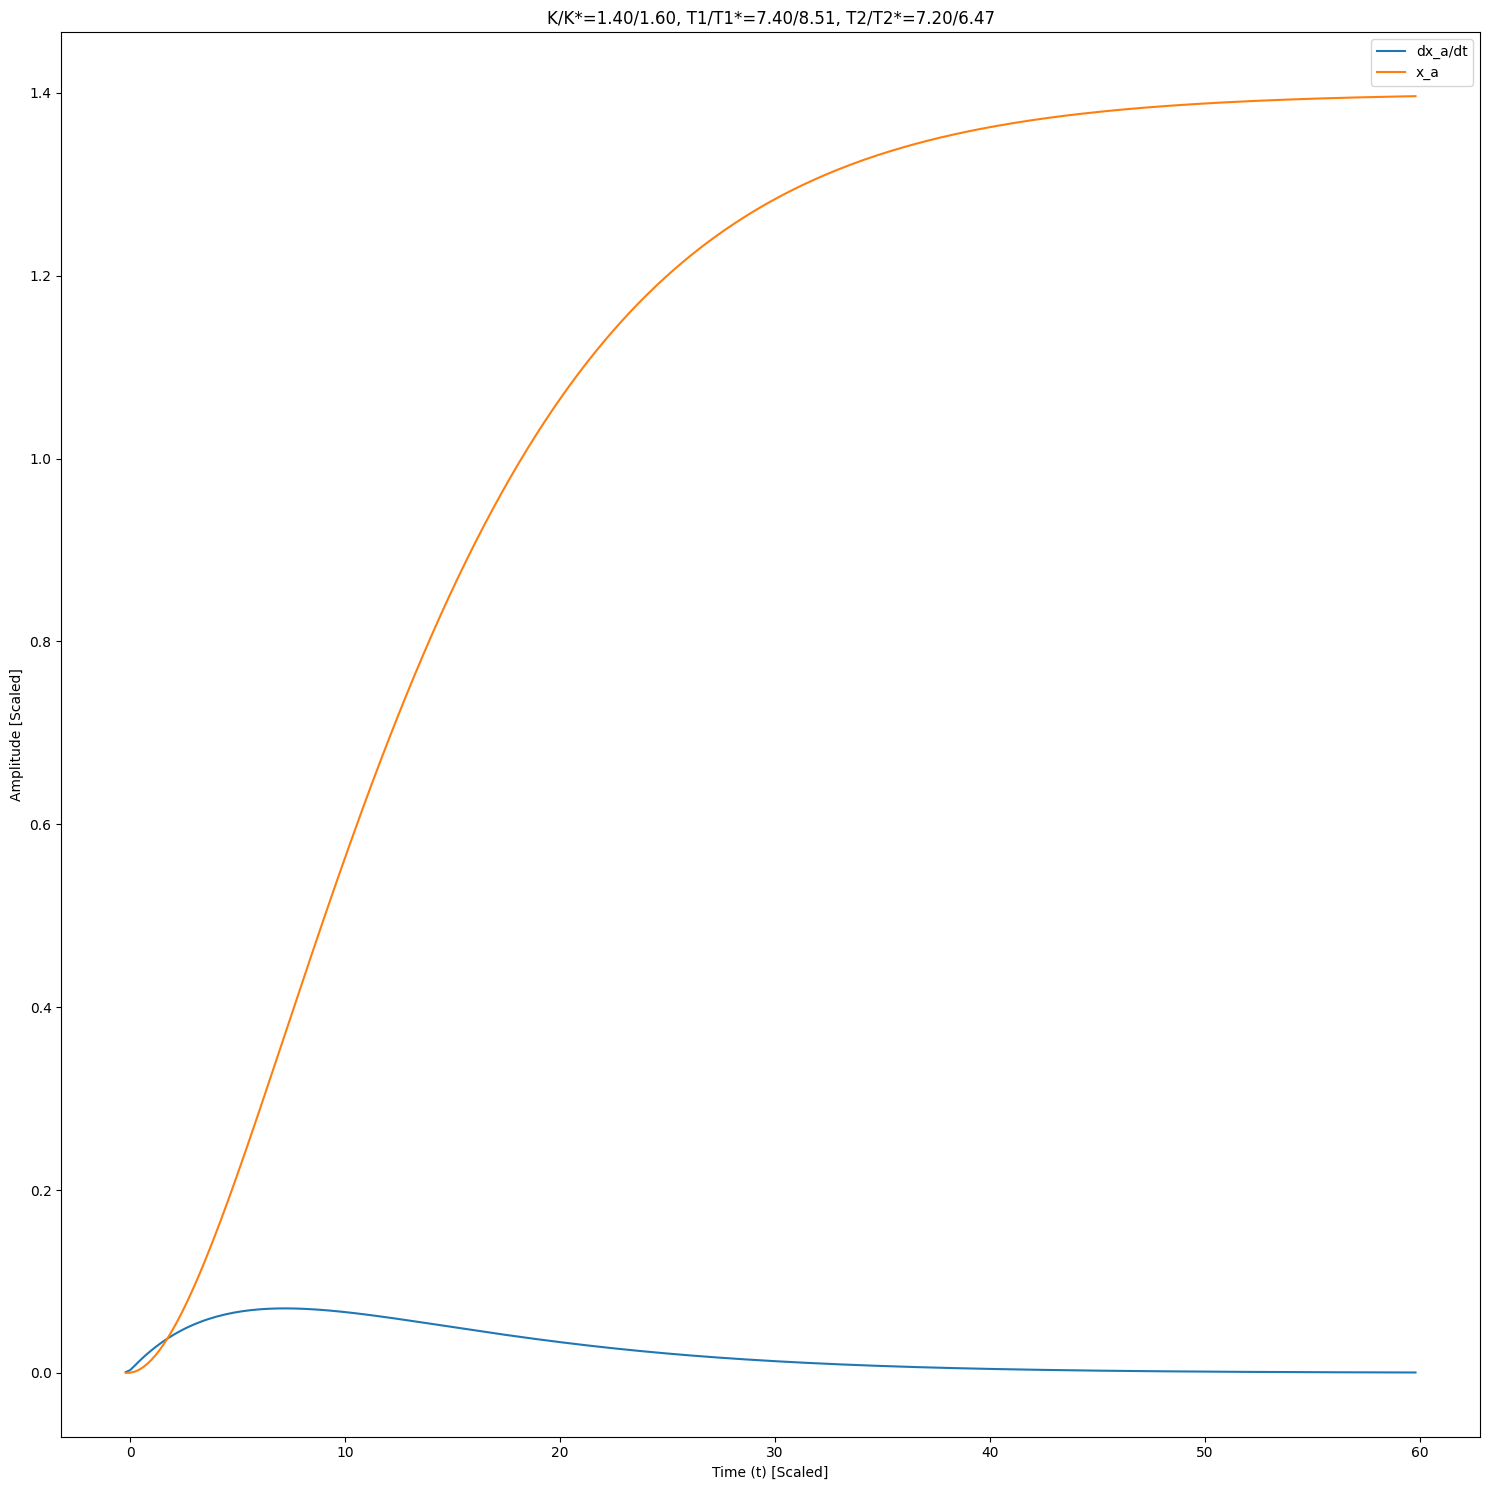

In [46]:
indexes = [222]
num_plots = len(indexes)

if num_plots == 0:
    print("No indexes provided to plot.")
else:
    # Determine subplot grid dimensions more robustly
    if num_plots == 1:
        nrows = 1
        ncols = 1
    elif num_plots <= 5: # Assuming a single row for up to 5 plots
        nrows = 1
        ncols = num_plots
    else: # More than 5 plots, use 5 columns
        ncols = 5
        nrows = (num_plots + ncols - 1) // ncols # Ceiling division

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))

    # Ensure 'axes' is always an iterable array (e.g., a 1D numpy array or list of Axes objects)
    if num_plots == 1:
        # If only one subplot, plt.subplots returns a single Axes object, not an array.
        # Wrap it in a list to make it iterable for the loop.
        axes_iterable = [axes]
    else:
        # For multiple subplots, axes is typically a numpy array (possibly 2D).
        # Flatten it to iterate over individual Axes objects easily.
        axes_iterable = axes.flatten()

    for idx in range(num_plots):
        i = indexes[idx]
        current_ax = axes_iterable[idx] # Use the current Axes object

        # These are scaled values from X_test_scaled
        t_data = X_test[i][:, 2]
        da_dt_data = X_test[i][:, 0]
        x_a_data = X_test[i][:, 1]

        # Inverse transform y_pred_scaled values to get actual K, T1, T2 for the title
        y_pred_unscaled_single = y_scaler.inverse_transform(y_pred_scaled[i].reshape(1, -1))[0]
        K_val = y_test[i][0]
        T1_val = y_test[i][1]
        T2_val = y_test[i][2]
        K_val_pred = y_pred_unscaled_single[0]
        T1_val_pred = y_pred_unscaled_single[1]
        T2_val_pred = y_pred_unscaled_single[2]
        current_ax.plot(t_data, da_dt_data, label='dx_a/dt')
        current_ax.plot(t_data, x_a_data, label='x_a')
        title = f'K/K*={K_val:.2f}/{K_val_pred:.2f}'
        title += f', T1/T1*={T1_val:.2f}/{T1_val_pred:.2f}'
        title += f', T2/T2*={T2_val:.2f}/{T2_val_pred:.2f}'
        current_ax.set_title(title)
        current_ax.legend()
        current_ax.set_xlabel('Time (t) [Scaled]') # Added [Scaled] to indicate data is scaled
        current_ax.set_ylabel('Amplitude [Scaled]') # Added [Scaled] to indicate data is scaled

    plt.tight_layout() # Adjust subplot params for a tight layout
    plt.show() # Display the figure

## RESULTS K

In [30]:
import pandas as pd

results_K = pd.DataFrame({
    'K_DIFF' : y_actual[:, 0] - y_pred[:, 0],
    'K_DIFF_%' : (100*(y_actual[:, 0] - y_pred[:, 0]) / y_actual[:, 0] ),
    'K_ACTUAL': y_actual[:, 0],
    'K_PRED' : y_pred[:, 0],
})
display(results_K)

,K_DIFF,K_DIFF_%,K_ACTUAL,K_PRED
0,0.002233,0.023018,9.7,9.697767
1,0.047838,0.759326,6.3,6.252162
2,-0.127752,-4.731569,2.7,2.827752
3,-0.096311,-1.660539,5.8,5.896311
4,-0.040354,-1.301747,3.1,3.140354
...,...,...,...,...
995,0.118134,2.002278,5.9,5.781866
996,-0.094821,-2.963150,3.2,3.294821
997,-0.009867,-0.137042,7.2,7.209867
998,-0.008306,-0.145725,5.7,5.708306


## RESULTS T1

In [32]:
results_T1 = pd.DataFrame({
    'T1_DIFF' : y_actual[:, 1] - y_pred[:, 1],
    'T1_DIFF_%' : 100*(y_actual[:, 1] - y_pred[:, 1]) / y_actual[:, 1],
    'T1_ACTUAL' : y_actual[:, 1],
    'T1_PRED' : y_pred[:, 1],
})

display(results_T1)


,T1_DIFF,T1_DIFF_%,T1_ACTUAL,T1_PRED
0,-0.173775,-3.697341,4.7,4.873775
1,-0.450905,-5.636311,8.0,8.450905
2,-0.065018,-0.706722,9.2,9.265018
3,-0.192037,-9.601843,2.0,2.192037
4,-0.117132,-1.183150,9.9,10.017132
...,...,...,...,...
995,-0.180181,-1.857539,9.7,9.880181
996,-0.209572,-2.302991,9.1,9.309572
997,-0.266144,-3.024364,8.8,9.066144
998,-0.345521,-5.007552,6.9,7.245521


## RESULTS T2

In [ ]:
results_T2 = pd.DataFrame({
    'T2_DIFF' : y_actual[:, 2] - y_pred[:, 2],
    'T2_DIFF_%' : 100*(y_actual[:, 2] - y_pred[:, 2]) / y_actual[:, 2],
    'T2_ACTUAL' : y_actual[:, 1],
    'T2_PRED' : y_pred[:, 1],
})

display(results_T2)

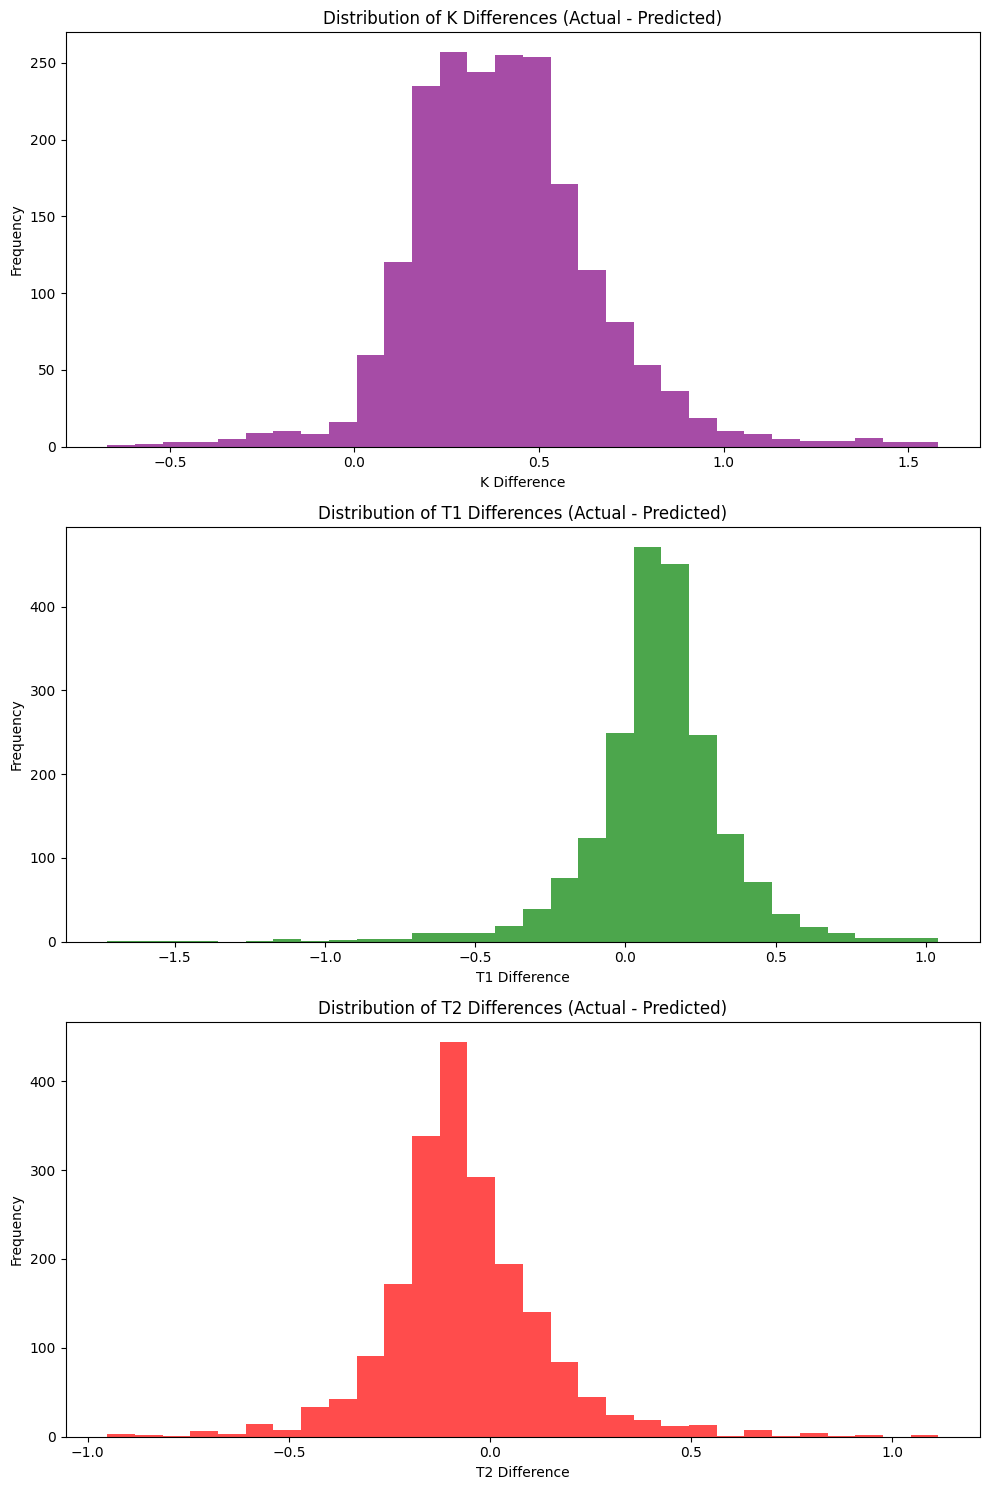

In [ ]:
import matplotlib.pyplot as plt

fig_diff, axes_diff = plt.subplots(3, 1, figsize=(10, 15))

# K_DIFF distribution
axes_diff[0].hist(results_df['K_DIFF'], bins=30, color='purple', alpha=0.7)
axes_diff[0].set_title('Distribution of K Differences (Actual - Predicted)')
axes_diff[0].set_xlabel('K Difference')
axes_diff[0].set_ylabel('Frequency')

# T1_DIFF distribution
axes_diff[1].hist(results_df['T1_DIFF'], bins=30, color='green', alpha=0.7)
axes_diff[1].set_title('Distribution of T1 Differences (Actual - Predicted)')
axes_diff[1].set_xlabel('T1 Difference')
axes_diff[1].set_ylabel('Frequency')

# T2_DIFF distribution
axes_diff[2].hist(results_df['T2_DIFF'], bins=30, color='red', alpha=0.7)
axes_diff[2].set_title('Distribution of T2 Differences (Actual - Predicted)')
axes_diff[2].set_xlabel('T2 Difference')
axes_diff[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()